In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf
import pandas as pd
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as scs
from scipy.interpolate import PchipInterpolator
from properscoring import crps_quadrature
import properscoring as ps
from scipy.stats import norm
from joblib import Parallel, delayed
from arch.utility.exceptions import DataScaleWarning
from arch.univariate.base import ConvergenceWarning
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
import numpy as np, pandas as pd, re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

LOOKBACK   = 60         # uses rows [t-LOOKBACK, ..., t-1]
H          = 30         # next-30d realized vol target
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15       

df = pd.read_csv("aluminium_raw_inputs.csv", parse_dates=["date"]).sort_values("date")

# daily core
df["log_returns"] = np.log(df["al_lme_prices"] / df["al_lme_prices"].shift(1))
df = df.dropna()

# realized 30d vol (annualized) and logs
df["vol"]     = df["log_returns"].rolling(30).std() * np.sqrt(252.0)
df["log_vol"] = np.log(df["vol"] + 1e-12)

# targets: NEXT 30d realized vol (no leakage)
df["target_vol"]     = df["vol"].shift(-H)
df["target_log_vol"] = np.log(df["target_vol"] + 1e-12)

# sign-aware shocks & leverage
r = df["log_returns"].astype(float)
df["abs_r"]  = r.abs()
df["sq_r"]   = r**2
df["sign_r"] = np.sign(r).replace({0.0: 0.0})
df["lev"]    = df["sign_r"] * df["sq_r"]

# downside/upside semivariances (weekly & monthly)
for k in [5, 22]:
    neg = (r < 0).astype(float)
    pos = (r > 0).astype(float)
    df[f"rs_neg_{k}"] = (df["sq_r"] * neg).rolling(k).mean()
    df[f"rs_pos_{k}"] = (df["sq_r"] * pos).rolling(k).mean()

# HAR-style realized var logs
for k in [1, 5, 22]:
    df[f"har_logrv_{k}"] = np.log(df["sq_r"].rolling(k).mean() * 252.0 + 1e-12)

# classic lagged log-vol (past-only)
df["lag1_log_vol"]  = df["log_vol"].shift(1)
df["lag7_log_vol"]  = df["log_vol"].shift(7)
df["lag30_log_vol"] = df["log_vol"].shift(30)

# drop rows hit by rolls/shifts/target; reindex
df = df.dropna().reset_index(drop=True)

T = len(df)
all_t = list(range(LOOKBACK, T))   
n_total = len(all_t)
n_tr  = int(np.floor(n_total * TRAIN_FRAC))
n_va  = int(np.floor(n_total * VAL_FRAC))
n_te  = n_total - n_tr - n_va
idx_tr_win = list(range(0, n_tr))
idx_va_win = list(range(n_tr, n_tr + n_va))
idx_te_win = list(range(n_tr + n_va, n_total))

cutoff_row = LOOKBACK + idx_tr_win[-1] + 1

# pca
def _extract_category(colname: str):
    m = re.match(r"\('FeatureName\.([A-Za-z0-9_]+)'\s*,", str(colname))
    return m.group(1) if m else None

cand_cols = [
    "log_returns","abs_r","sq_r","sign_r","lev",
    "rs_neg_5","rs_pos_5","rs_neg_22","rs_pos_22",
    "har_logrv_1","har_logrv_5","har_logrv_22",
    "log_vol","lag1_log_vol","lag7_log_vol","lag30_log_vol","garch30_logvol_feat"  # garch feat filled later
]

categories = {}
for c in df.columns:
    cat = _extract_category(c)
    if cat:
        categories.setdefault(cat, []).append(c)

MIN_CAT_COLS     = 2
MIN_TRAIN_ROWS   = 50
MAX_PCS_CONSIDER = 6
PCVOL_WINDOWS    = [5, 22, 30]
PCVOL_CORR_THR   = 0.20

kept_pcvol_names = []
train_slice = slice(0, cutoff_row)

for cat, cols in categories.items():
    cols = [c for c in cols if c in df.columns]
    if len(cols) < MIN_CAT_COLS:
        continue
    sub = df.loc[train_slice, cols + ["target_log_vol"]].dropna()
    if sub.shape[0] < MIN_TRAIN_ROWS:
        continue

    X_tr_p = sub[cols].to_numpy(np.float64)
    scaler_p = StandardScaler().fit(X_tr_p)
    pca = PCA().fit(scaler_p.transform(X_tr_p))

    train_means_p = df.loc[train_slice, cols].mean(skipna=True)
    X_full = df[cols].fillna(train_means_p).to_numpy(np.float64)
    comps_full = pca.transform(scaler_p.transform(X_full))   # (T, p)

    p = min(comps_full.shape[1], MAX_PCS_CONSIDER)
    tmp_feat_df = {}
    pc_names_this_cat = []
    for j in range(p):
        pc_series = pd.Series(comps_full[:, j], index=df.index)
        dpc = pc_series.diff()
        for k in PCVOL_WINDOWS:
            name = f"{cat}_PC{j+1}_vol{k}"
            tmp_feat_df[name] = np.log(dpc.rolling(k).std() * np.sqrt(252.0) + 1e-12)
            pc_names_this_cat.append(name)

    if not pc_names_this_cat:
        continue

    eval_frame = pd.concat([df[["target_log_vol"]], pd.DataFrame(tmp_feat_df, index=df.index)], axis=1)
    sub_train = eval_frame.loc[train_slice, ["target_log_vol"] + pc_names_this_cat].dropna()
    if sub_train.shape[0] < 5:
        continue
    corr_vec = sub_train.corr(numeric_only=True)["target_log_vol"].drop("target_log_vol", errors="ignore")
    kept = [f for f in pc_names_this_cat if abs(float(corr_vec.get(f, np.nan))) >= PCVOL_CORR_THR]
    for f in kept:
        df[f] = eval_frame[f]
        kept_pcvol_names.append(f)
        cand_cols.append(f)

# GARCH(1,1) feature 
from arch import arch_model

def build_garch30_log_feature_full_series(df_: pd.DataFrame, cutoff_row_: int, H_: int = 30) -> np.ndarray:
    returns = df_["log_returns"].to_numpy(float)
    T_ = len(returns)
    out = np.empty(T_, float); out[:] = np.nan
    sigma2 = np.empty(T_, float); sigma2[:] = np.nan

    train_r = returns[:cutoff_row_]
    if train_r.size < 100:
        lam = 0.94
        sigma2[0] = np.var(train_r) if train_r.size > 1 else np.var(returns[:max(2, cutoff_row_+1)])
        for t in range(1, cutoff_row_):
            sigma2[t] = lam * sigma2[t-1] + (1-lam) * (returns[t-1]**2)
        for t in range(cutoff_row_, T_):
            sigma2[t] = lam * sigma2[t-1] + (1-lam) * (returns[t-1]**2)
        omega = (1-lam) * np.mean(train_r**2); alpha = 1 - lam; beta = lam; phi = alpha + beta
    else:
        try:
            am  = arch_model(train_r, mean="Zero", vol="Garch", p=1, q=1, dist="normal")
            res = am.fit(disp="off")
            omega = float(res.params["omega"]); alpha = float(res.params["alpha[1]"]); beta = float(res.params["beta[1]"])
            phi   = alpha + beta
            if not np.isfinite(phi) or phi >= 0.999:
                phi = 0.999; unconditional = np.var(train_r); omega = unconditional * (1 - phi)
            sigma2[:cutoff_row_] = np.asarray(res.conditional_volatility, float)**2
            for t in range(cutoff_row_, T_):
                sigma2[t] = omega + alpha * (returns[t-1]**2) + beta * sigma2[t-1]
        except Exception:
            lam = 0.94
            sigma2[0] = np.var(train_r) if train_r.size > 1 else np.var(returns[:max(2, cutoff_row_+1)])
            for t in range(1, cutoff_row_):
                sigma2[t] = lam * sigma2[t-1] + (1-lam) * (returns[t-1]**2)
            for t in range(cutoff_row_, T_):
                sigma2[t] = lam * sigma2[t-1] + (1-lam) * (returns[t-1]**2)
            omega = (1-lam) * np.mean(train_r**2); alpha = 1 - lam; beta = lam; phi = alpha + beta

    for j in range(T_):
        sigma2_1 = omega + alpha * (returns[j]**2) + beta * sigma2[j]
        s = 0.0; sig_h = sigma2_1
        for _ in range(H_):
            s += sig_h
            sig_h = omega + (alpha + beta) * sig_h
        var_win = s / H_
        vol_win = np.sqrt(var_win) * np.sqrt(252.0)
        out[j] = np.log(vol_win + 1e-8)
    return out

df["garch30_logvol_feat"] = build_garch30_log_feature_full_series(df, cutoff_row, H_=H)
if "garch30_logvol_feat" not in cand_cols:
    cand_cols.append("garch30_logvol_feat")

df_base = df[["date"] + cand_cols + ["target_log_vol"]].copy()
df_base["al_lme_prices"] = df["al_lme_prices"]  # ensure present for diagnostics

corr_train = (
    df_base.iloc[:cutoff_row]
          .drop(columns=["date"])
          .corr()["target_log_vol"]
          .abs()
          .sort_values(ascending=False)
)

thr = 0.10
keep = [c for c in cand_cols if c in corr_train.index and corr_train[c] >= thr]
if not keep:
    keep = ["log_vol","lag1_log_vol","har_logrv_5","har_logrv_22","abs_r","sq_r","lev",
            "garch30_logvol_feat","al_lme_prices","log_returns"]
else:
    for mandatory in ["al_lme_prices","log_returns"]:
        if mandatory not in keep:
            keep.append(mandatory)

print(f"[LSTM] Selected {len(keep)} features (|corr| ≥ {thr:.2f}).")

#  Build windows 
X_list, y_list = [], []
train_means_F = df_base.loc[:cutoff_row-1, keep].mean(numeric_only=True)
F_df = df_base[keep].copy().fillna(train_means_F)

F   = F_df.to_numpy(np.float64)
y_l = df_base["target_log_vol"].to_numpy(np.float64)

for t in all_t:                           
    x_win = F[t-LOOKBACK:t, :]
    X_list.append(x_win)
    y_list.append(y_l[t])

y = np.asarray(y_list, dtype=np.float64)

X_tr_list = [X_list[i] for i in idx_tr_win]
X_va_list = [X_list[i] for i in idx_va_win]
X_te_list = [X_list[i] for i in idx_te_win]
y_tr_log  = y[idx_tr_win]; y_va_log = y[idx_va_win]; y_te_log = y[idx_te_win]

# Scale inputs/targets with TRAIN-only stats 
stack_tr = np.concatenate(X_tr_list, axis=0)
scaler_X = StandardScaler().fit(stack_tr)

X_tr_list = [scaler_X.transform(x) for x in X_tr_list]
X_va_list = [scaler_X.transform(x) for x in X_va_list]
X_te_list = [scaler_X.transform(x) for x in X_te_list]

def _tabulate(lst): return np.stack(lst, axis=0).astype(np.float32)
X_tr = _tabulate(X_tr_list)
X_va = _tabulate(X_va_list)
X_te = _tabulate(X_te_list)

scaler_y = StandardScaler().fit(y_tr_log.reshape(-1,1))
y_tr = scaler_y.transform(y_tr_log.reshape(-1,1)).ravel().astype(np.float32)
y_va = scaler_y.transform(y_va_log.reshape(-1,1)).ravel().astype(np.float32)
y_te = scaler_y.transform(y_te_log.reshape(-1,1)).ravel().astype(np.float32)

print("Shapes — X_tr", X_tr.shape, "X_va", X_va.shape, "X_te", X_te.shape)
print("Targets — y_tr", y_tr.shape, "y_va", y_va.shape, "y_te", y_te.shape)

kept_feature_names = keep


[LSTM] Selected 34 features (|corr| ≥ 0.10).
Shapes — X_tr (1607, 60, 34) X_va (344, 60, 34) X_te (345, 60, 34)
Targets — y_tr (1607,) y_va (344,) y_te (345,)


/cs/student/msc/dsml/2024/eborso/gpu_env/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
class QuantileLossWithCalibration(nn.Module):
    def __init__(self, quantiles, weights=None, lambda_cal=0.05, tau=0.6,
                 lambda_spread=5e-5, min_spread=0.05):
        super().__init__()
        self.q = torch.tensor(quantiles).view(1, -1)  # (1, nq)
        self.register_buffer("_qbuf", self.q)
        self.lambda_cal   = float(lambda_cal)
        self.tau          = float(tau)
        self.lambda_spread= float(lambda_spread)
        self.min_spread   = float(min_spread)
        if weights is None:

            w = torch.tensor([0.5, 0.7, 0.8, 1.2, 2.0, 1.2, 0.8, 0.7, 0.5], dtype=torch.float32)
            w = w / w.sum()
        else:
            w = torch.tensor(weights, dtype=torch.float32)
            w = w / w.sum()
        self.register_buffer("w", w.view(1, -1))

    def forward(self, preds, target):
        if preds.dim() == 3: preds = preds.squeeze(1)
        if target.dim() == 1: target = target.unsqueeze(1)
        q = self._qbuf
        w = self.w

        err = target - preds                   
        pinball = torch.maximum((q - 1.0) * err, q * err)  
        pinball = (w * pinball).sum(dim=1).mean()          

        cal_loss = torch.tensor(0., device=preds.device)
        if self.lambda_cal > 0.0:
            soft_ind = torch.sigmoid(err / self.tau)       
            empirical_cov = soft_ind.mean(dim=0)           
            expected_cov  = (1.0 - q).squeeze(0)
            cal_loss = F.mse_loss(empirical_cov, expected_cov)

        spread_loss = torch.tensor(0., device=preds.device)
        if self.lambda_spread > 0.0 and preds.size(1) > 1:
            deltas = preds[:, 1:] - preds[:, :-1]
            spread_loss = F.softplus(self.min_spread - deltas).mean()

        return pinball + self.lambda_cal * cal_loss + self.lambda_spread * spread_loss


In [ ]:
import torch
import torch.nn as nn

class QuantileLSTM(nn.Module):
    """
    LSTM monotonic quantile head.
    Returns quantiles with shape (B, nq) for each sequence in the batch.

    Args:
        input_size  : number of features per time step
        quantiles   : list of quantiles (e.g., [0.01, 0.05, ..., 0.99])
        hidden_size : LSTM hidden size (default 128)
        num_layers  : number of LSTM layers (default 2)
        dropout     : dropout between LSTM layers and before the head (default 0.2)
    """
    def __init__(
        self,
        input_size: int,
        quantiles,
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.quantiles = list(quantiles)
        self.nq = len(self.quantiles)

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        self.dropout = nn.Dropout(dropout)

        self.head = nn.Linear(hidden_size, 1 + (self.nq - 1))
        self.softplus = nn.Softplus()  # ensures deltas >= 0

        self._init_weights()

    def _init_weights(self):
        # FC init: small weights; bias gives initial spacing between quantiles
        nn.init.xavier_uniform_(self.head.weight)
        with torch.no_grad():
            self.head.bias.zero_()
            if self.nq > 1:
                # base ≈ 0, deltas ≈ 0.1 to avoid collapsed quantiles at start
                self.head.bias.data[0] = 0.0
                self.head.bias.data[1:] = 0.10

    def forward(self, x):
        """
        x: (B, T, F) = (batch, seq_len, input_size)
        returns: (B, nq)
        """
        # LSTM encoding
        h, _ = self.lstm(x)          
        h = self.dropout(h)
        h_last = h[:, -1, :]        

        # Monotone quantile head
        z = self.head(h_last)        
        base  = z[:, :1]             
        deltas = self.softplus(z[:, 1:])  
        q_vals = torch.cat([base, base + torch.cumsum(deltas, dim=1)], dim=1)  # (B,nq)
        return q_vals


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, criterion, optimizer, X_train, y_train, batch_size):
    model.train()
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)  # <-- add view(-1,1)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    total_loss = 0.0
    for batch_X, batch_Y in dataloader:
        optimizer.zero_grad()
        preds = model(batch_X)                 
        loss  = criterion(preds, batch_Y)      
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def val_loss_one_epoch(model, criterion, X_val, y_val, batch_size):
    model.eval()
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device).view(-1, 1)     

    dataset = TensorDataset(X_val_tensor, y_val_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=False)

    total_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in dataloader:
            preds = model(batch_X)
            loss  = criterion(preds, batch_Y)
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [ ]:
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
saved_results_unified = {
    "all_actuals": [],
    "all_dates": [],
}
for q in quantiles:
    saved_results_unified[f"quantile_{int(q*100)}"] = []

# Hyperparameters
input_size = X_tr.shape[-1]     
output_size = 1                   
quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]      
hidden_size = 128
learning_rate = 5e-4
max_epochs = 50
batch_size = 128
patience = 10

model = QuantileLSTM(input_size=input_size, hidden_size=hidden_size, quantiles=quantiles, num_layers=1, dropout=0.3)
criterion = QuantileLossWithCalibration(quantiles, lambda_cal=1, tau=0.3, lambda_spread=1e-4, min_spread=0.02).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
sched = sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=15, verbose=True)
model.to(device)


import numpy as np, torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader

# ---------- hyperparams you can tweak ----------
MAX_EPOCHS     = 200
MIN_EPOCHS     = 30          # <-- do NOT early-stop before this
PATIENCE       = 40          # epochs after MIN_EPOCHS without improvement (on smoothed val)
MIN_DELTA      = 1e-4        # required improvement (absolute)
SMOOTH_K       = 5           # EMA/rolling smoothing of val loss
EVAL_EVERY     = 1           # evaluate every N epochs
BATCH_SIZE     = 256
LR             = 5e-4
WEIGHT_DECAY   = 2e-4
CLIP_NORM      = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _make_loader(X, y, bs, shuffle):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32).view(-1,1)
    return DataLoader(TensorDataset(X_t, y_t), batch_size=bs, shuffle=shuffle, drop_last=shuffle)

train_loader = _make_loader(X_tr, y_tr, BATCH_SIZE, shuffle=True)
val_loader   = _make_loader(X_va, y_va, BATCH_SIZE, shuffle=False)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=8, verbose=True, min_lr=1e-6)

best_state = None
best_val   = np.inf
epochs_no_improve = 0
val_hist, val_hist_smooth = [], []

def _smooth(vals, k=SMOOTH_K):
    if len(vals) < k: 
        return np.mean(vals)
    x = np.array(vals[-k:], dtype=float)
    return float(np.mean(x))

for epoch in range(1, MAX_EPOCHS+1):
    # ---- train ----
    model.train()
    train_loss_epoch = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        train_loss_epoch += loss.item()
    train_loss_epoch /= max(1, len(train_loader))

    # ---- validate ----
    do_eval = (epoch % EVAL_EVERY == 0)
    if do_eval:
        model.eval()
        with torch.no_grad():
            val_loss_epoch = 0.0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss_epoch += criterion(preds, yb).item()
            val_loss_epoch /= max(1, len(val_loader))

        val_hist.append(val_loss_epoch)
        smoothed = _smooth(val_hist, SMOOTH_K)
        val_hist_smooth.append(smoothed)

        scheduler.step(smoothed)

        #  early stopping logic 
        improved = (best_val - smoothed) > MIN_DELTA
        if improved:
            best_val = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            if epoch >= MIN_EPOCHS:
                epochs_no_improve += 1

        if epoch % 20 == 0 or epoch <= 5:
            print(f"Epoch {epoch:03d} | train {train_loss_epoch:.4f} | val {val_loss_epoch:.4f} | val_smooth {smoothed:.4f} | lr {optimizer.param_groups[0]['lr']:.2e}")

        if (epoch >= MIN_EPOCHS) and (epochs_no_improve >= PATIENCE):
            print(f"Early stopping at epoch {epoch} — best smoothed val: {best_val:.6f}")
            break

# restore best weights
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

y_test_original = scaler_y.inverse_transform(y_te.reshape(-1, 1)).ravel()

with torch.no_grad():
    test_quantile_preds = model(torch.tensor(X_te, dtype=torch.float32, device=device))

preds = test_quantile_preds.cpu().numpy() 

mu  = scaler_y.mean_[0]
std = scaler_y.scale_[0]
preds_inv = preds * std + mu                         

# Save
saved_results_unified["all_actuals"].extend(y_test_original.tolist())
for q_idx, q in enumerate(quantiles):
    key = f"quantile_{int(q*100)}"
    saved_results_unified[key].extend(preds_inv[:, q_idx].tolist())


Epoch 001 | train 1.2449 | val 0.9731 | val_smooth 0.9731 | lr 5.00e-04
Epoch 002 | train 1.0012 | val 0.8121 | val_smooth 0.8926 | lr 5.00e-04
Epoch 003 | train 0.7063 | val 0.6077 | val_smooth 0.7976 | lr 5.00e-04
Epoch 004 | train 0.3785 | val 0.3367 | val_smooth 0.6824 | lr 5.00e-04
Epoch 005 | train 0.3023 | val 0.2119 | val_smooth 0.5883 | lr 5.00e-04
Epoch 020 | train 0.1217 | val 0.3023 | val_smooth 0.2589 | lr 2.50e-04
Epoch 040 | train 0.1022 | val 0.3126 | val_smooth 0.3085 | lr 6.25e-05
Epoch 060 | train 0.0974 | val 0.3162 | val_smooth 0.3154 | lr 1.56e-05
Early stopping at epoch 69 — best smoothed val: 0.178575


In [25]:
overall_metrics = {}

actuals = np.array(saved_results_unified["all_actuals"])
pred_1 = np.array(saved_results_unified["quantile_1"])
pred_5 = np.array(saved_results_unified["quantile_5"])
pred_10 = np.array(saved_results_unified["quantile_10"])
pred_25 = np.array(saved_results_unified["quantile_25"])
pred_50 = np.array(saved_results_unified["quantile_50"])
pred_75 = np.array(saved_results_unified["quantile_75"])
pred_90= np.array(saved_results_unified["quantile_90"])
pred_95 = np.array(saved_results_unified["quantile_95"])
pred_99 = np.array(saved_results_unified["quantile_99"])

coverage_bool_99 = (actuals <= pred_99)
overall_coverage_99 = np.mean(coverage_bool_99) * 100
print(f"violations 99 quantile : {coverage_bool_99.shape[0] - np.sum(coverage_bool_99)}")
overall_std_99 = np.std(coverage_bool_99) * 100

coverage_bool_95 = (actuals <= pred_95)
overall_coverage_95 = np.mean(coverage_bool_95) * 100
overall_std_95 = np.std(coverage_bool_95) * 100

coverage_bool_90 = (actuals <= pred_90)
overall_coverage_90 = np.mean(coverage_bool_90) * 100
overall_std_90 = np.std(coverage_bool_90) * 100

coverage_bool_75 = (actuals <= pred_75)
overall_coverage_75 = np.mean(coverage_bool_75) * 100
overall_std_75 = np.std(coverage_bool_75) * 100

coverage_bool_50 = (actuals <= pred_50)
overall_coverage_50 = np.mean(coverage_bool_50) * 100
overall_std_50 = np.std(coverage_bool_50) * 100

coverage_bool_25 = (actuals <= pred_25)
overall_coverage_25 = np.mean(coverage_bool_25) * 100
overall_std_25 = np.std(coverage_bool_25) * 100

coverage_bool_10 = (actuals <= pred_10)
overall_coverage_10 = np.mean(coverage_bool_10) * 100
overall_std_10 = np.std(coverage_bool_10) * 100

coverage_bool_5 = (actuals <= pred_5)
overall_coverage_5 = np.mean(coverage_bool_5) * 100
overall_std_5 = np.std(coverage_bool_5) * 100

coverage_bool_1 = (actuals <= pred_1)
overall_coverage_1 = np.mean(coverage_bool_1) * 100
overall_std_1 = np.std(coverage_bool_1) * 100

overall_metrics = {
    "Coverage 99 (%)": overall_coverage_99,
    "std_99" : overall_std_99,
    "Coverage 95 (%)": overall_coverage_95,
    "std_95" : overall_std_95,
    "Coverage 90 (%)": overall_coverage_90,
    "std_90" : overall_std_90,
    "Coverage 75 (%)": overall_coverage_75,
    "std_75" : overall_std_75,
    "Coverage 50 (%)": overall_coverage_50,
    "std_50" : overall_std_50,
    "Coverage 25 (%)": overall_coverage_25,
    "std_25" : overall_std_25,
    "Coverage 10 (%)": overall_coverage_10,
    "std_10" : overall_std_10,
    "Coverage 5 (%)": overall_coverage_5,
    "std_5" : overall_std_5,
    "Coverage 1 (%)": overall_coverage_1,
    "std_1" : overall_std_1
}

print("=== Overall Metrics Across All Splits ===\n")

print(f" - Overall Coverage 99 : {overall_metrics['Coverage 99 (%)']:.2f}% (+- {overall_metrics['std_99']})")
print(f" - Overall Coverage 95 : {overall_metrics['Coverage 95 (%)']:.2f}% (+- {overall_metrics['std_95']})")
print(f" - Overall Coverage 90 : {overall_metrics['Coverage 90 (%)']:.2f}% (+- {overall_metrics['std_90']})")
print(f" - Overall Coverage 75 : {overall_metrics['Coverage 75 (%)']:.2f}% (+- {overall_metrics['std_75']})")
print(f" - Overall Coverage 50 : {overall_metrics['Coverage 50 (%)']:.2f}% (+- {overall_metrics['std_50']})")
print(f" - Overall Coverage 25 : {overall_metrics['Coverage 25 (%)']:.2f}% (+- {overall_metrics['std_25']})")
print(f" - Overall Coverage 10 : {overall_metrics['Coverage 10 (%)']:.2f}% (+- {overall_metrics['std_10']})")
print(f" - Overall Coverage 5 : {overall_metrics['Coverage 5 (%)']:.2f}% (+- {overall_metrics['std_5']})")
print(f" - Overall Coverage 1 : {overall_metrics['Coverage 1 (%)']:.2f}% (+- {overall_metrics['std_1']})")
print()

violations 99 quantile : 0
=== Overall Metrics Across All Splits ===

 - Overall Coverage 99 : 100.00% (+- 0.0)
 - Overall Coverage 95 : 98.84% (+- 10.705034963837326)
 - Overall Coverage 90 : 88.41% (+- 32.01553918025294)
 - Overall Coverage 75 : 60.87% (+- 48.80422678400792)
 - Overall Coverage 50 : 47.83% (+- 49.952718665548076)
 - Overall Coverage 25 : 22.03% (+- 41.44420765615102)
 - Overall Coverage 10 : 6.38% (+- 24.433940192124755)
 - Overall Coverage 5 : 0.87% (+- 9.284415871331575)
 - Overall Coverage 1 : 0.00% (+- 0.0)



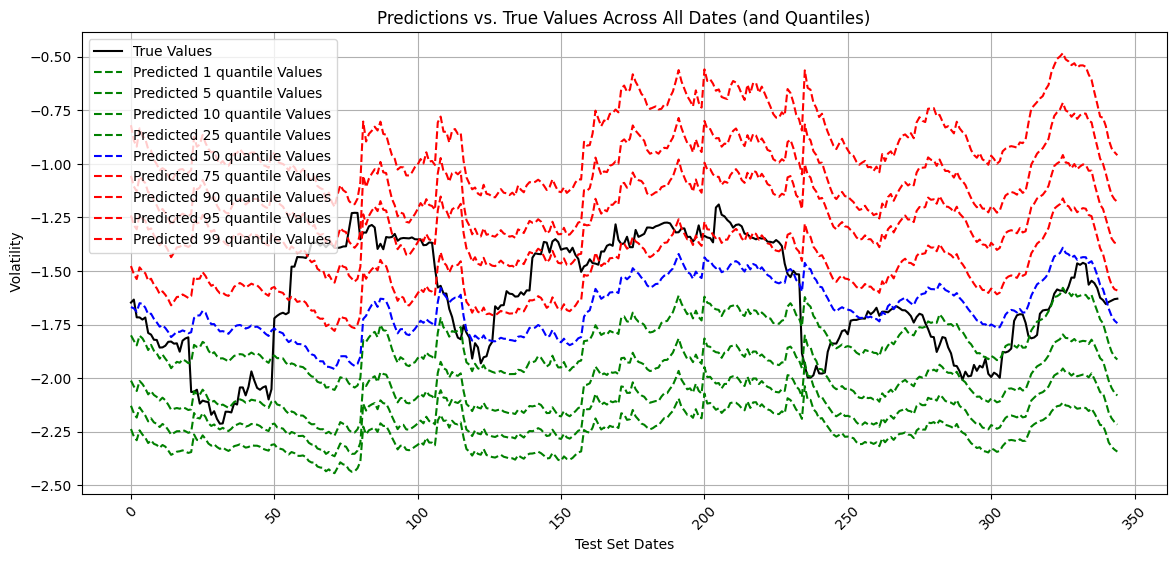

In [26]:
min_length = min(
    len(saved_results_unified["all_actuals"]), 
    len(saved_results_unified["quantile_1"]),
)

true = np.array(saved_results_unified["all_actuals"][:min_length])
pred_1 = np.array(saved_results_unified["quantile_1"][:min_length])
pred_5 = np.array(saved_results_unified["quantile_5"][:min_length])
pred_10 = np.array(saved_results_unified["quantile_10"][:min_length])
pred_25 = np.array(saved_results_unified["quantile_25"][:min_length])
pred_50 = np.array(saved_results_unified["quantile_50"][:min_length])
pred_75 = np.array(saved_results_unified["quantile_75"][:min_length])
pred_90 = np.array(saved_results_unified["quantile_90"][:min_length])
pred_95 = np.array(saved_results_unified["quantile_95"][:min_length])
pred_99 = np.array(saved_results_unified["quantile_99"][:min_length])



plt.figure(figsize=(14, 6))
plt.plot(true, label=f"True Values", color="black", linestyle="-")
plt.plot(pred_1, label=f"Predicted 1 quantile Values", color="green", linestyle="--")
plt.plot(pred_5, label=f"Predicted 5 quantile Values", color="green", linestyle="--")
plt.plot(pred_10, label=f"Predicted 10 quantile Values", color="green", linestyle="--")
plt.plot(pred_25, label=f"Predicted 25 quantile Values", color="green", linestyle="--")
plt.plot(pred_50, label=f"Predicted 50 quantile Values", color="blue", linestyle="--")
plt.plot(pred_75, label=f"Predicted 75 quantile Values", color="red", linestyle="--")
plt.plot(pred_90, label=f"Predicted 90 quantile Values", color="red", linestyle="--")
plt.plot(pred_95, label=f"Predicted 95 quantile Values", color="red", linestyle="--")
plt.plot(pred_99, label=f"Predicted 99 quantile Values", color="red", linestyle="--")

plt.xlabel("Test Set Dates")
plt.ylabel(f" Volatility")
plt.title(f"Predictions vs. True Values Across All Dates (and Quantiles)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quantile_preds(model, X, y, quantiles, scaler_y=None,
                        title="Quantile Forecasts", n_points=200):
    """
    Plot actual targets vs predicted quantiles and print MAE/MSE using the median.
    Returns a dict with {'MAE': ..., 'MSE': ...} on the (unscaled) log-vol scale.
    """
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        X_t   = torch.tensor(X, dtype=torch.float32, device=device)
        preds = model(X_t).cpu().numpy()  # (N, nq)

    y_true = y.reshape(-1, 1)
    if scaler_y is not None:
        y_true = scaler_y.inverse_transform(y_true).ravel()
        mu, std = scaler_y.mean_[0], scaler_y.scale_[0]
        preds   = preds * std + mu
    else:
        y_true = y_true.ravel()

    if n_points is not None and n_points < len(y_true):
        y_true_plot = y_true[-n_points:]
        preds_plot  = preds[-n_points:]
    else:
        y_true_plot = y_true
        preds_plot  = preds

    #  metrics from median 
    try:
        i_med = quantiles.index(0.5)
    except ValueError:
        raise ValueError("Quantiles list must include 0.5 to compute median MAE/MSE.")
    y_hat_med = preds_plot[:, i_med]
    mae = float(np.mean(np.abs(y_true_plot - y_hat_med)))
    mse = float(np.mean((y_true_plot - y_hat_med)**2))
    print(f"[{title}]  MAE(median)={mae:.6f}   MSE(median)={mse:.6f}")

    #  plot 
    plt.figure(figsize=(14,4))
    plt.plot(y_true_plot, label="Actual", color="C0")
    plt.plot(y_hat_med, label="Median (0.5)", color="C1")

    for q_low, q_high in [(0.05, 0.95)]:
        i_low, i_high = quantiles.index(q_low), quantiles.index(q_high)
        plt.fill_between(
            range(len(y_true_plot)),
            preds_plot[:, i_low],
            preds_plot[:, i_high],
            alpha=0.20,
            label=f"90% band"
        )

    plt.legend()
    plt.title(title)
    plt.xlabel("Time (last n points)")
    plt.ylabel("Target (log-vol)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/lstm/{title.replace(' ', '_').lower()}.png", dpi=160)
    plt.show()

    return {"MAE": mae, "MSE": mse}


[Training set]  MAE(median)=0.143826   MSE(median)=0.034948


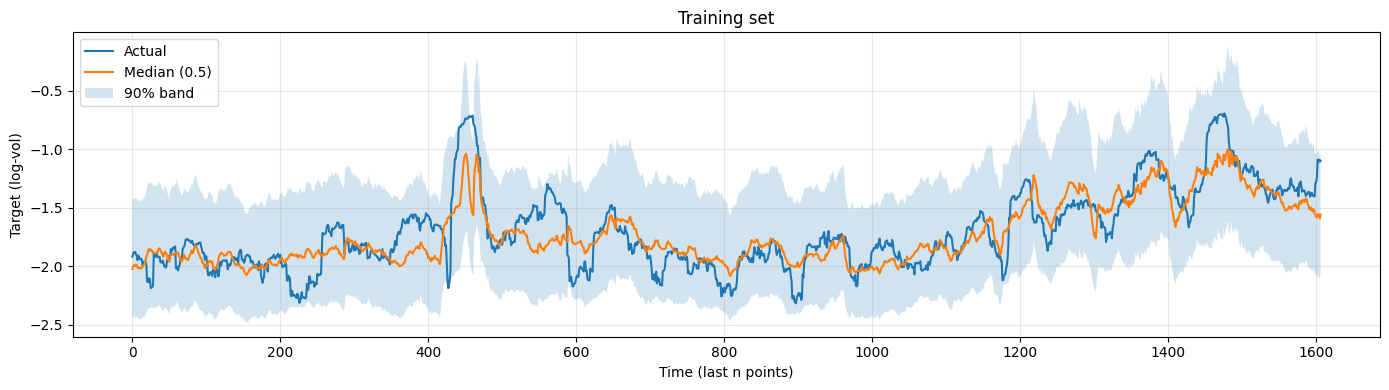

[Validation set]  MAE(median)=0.220282   MSE(median)=0.077644


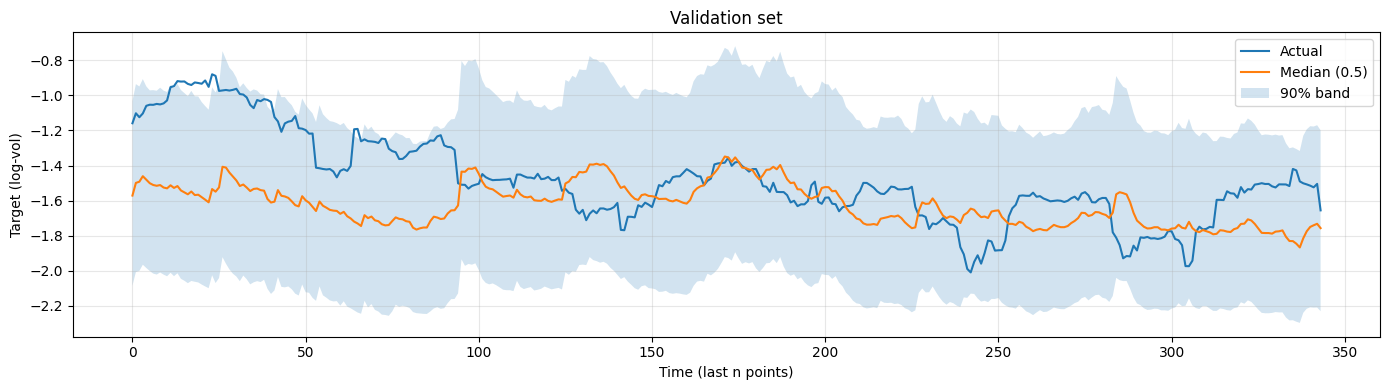

[Test set]  MAE(median)=0.221146   MSE(median)=0.072740


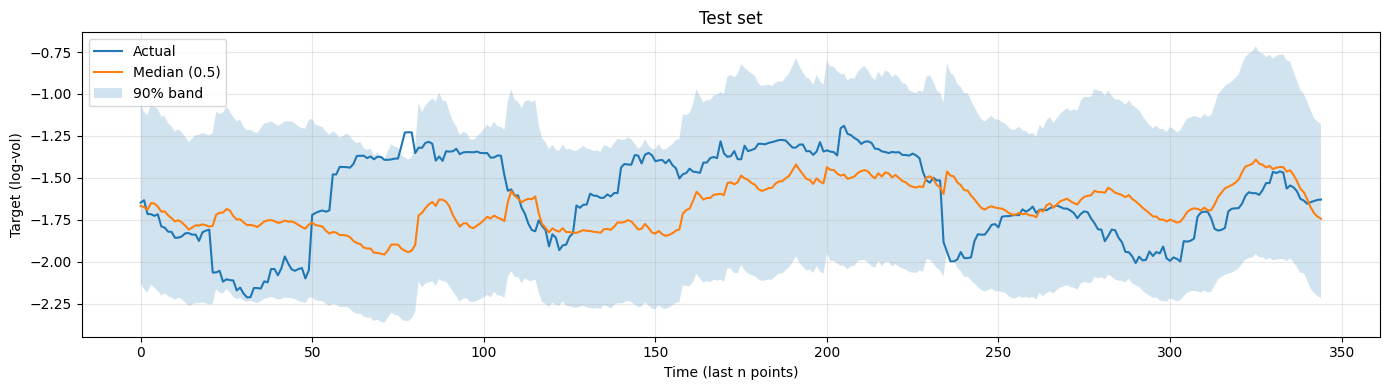

{'MAE': 0.22114580869674683, 'MSE': 0.07273992151021957}

In [56]:
plot_quantile_preds(model, X_tr, y_tr, quantiles, scaler_y=scaler_y, title="Training set", n_points=None)
plot_quantile_preds(model, X_va, y_va, quantiles, scaler_y=scaler_y, title="Validation set", n_points=None)
plot_quantile_preds(model, X_te, y_te, quantiles, scaler_y=scaler_y, title="Test set", n_points=None)


[test] MAE=0.221146  MSE=0.072740  Cov90=0.980  Width90=1.057454  IS90=1.088759  CRPS=0.150215


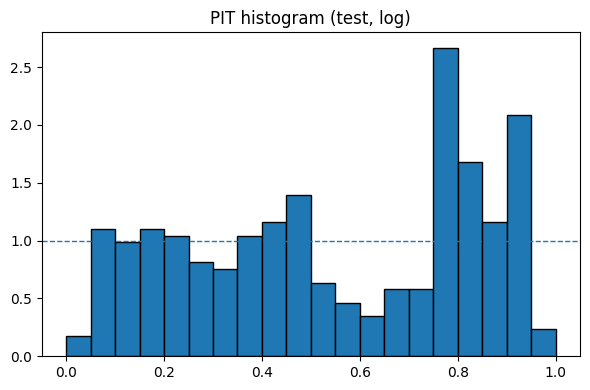

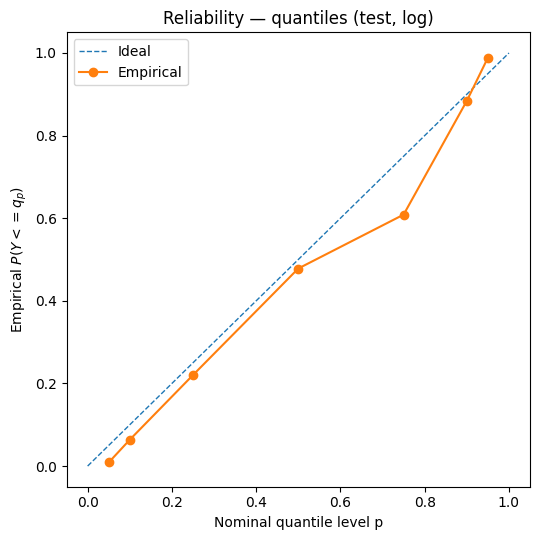

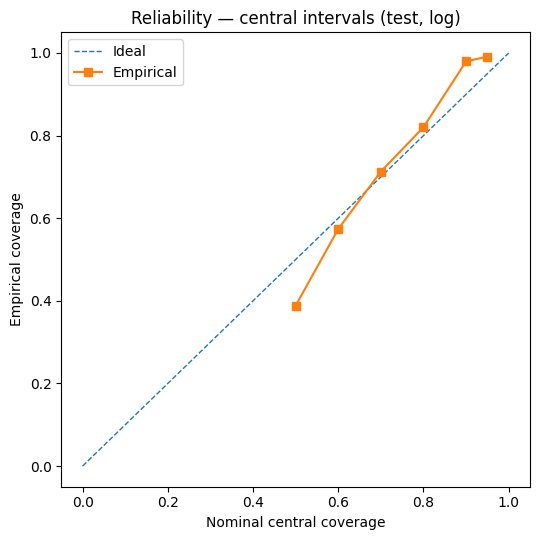

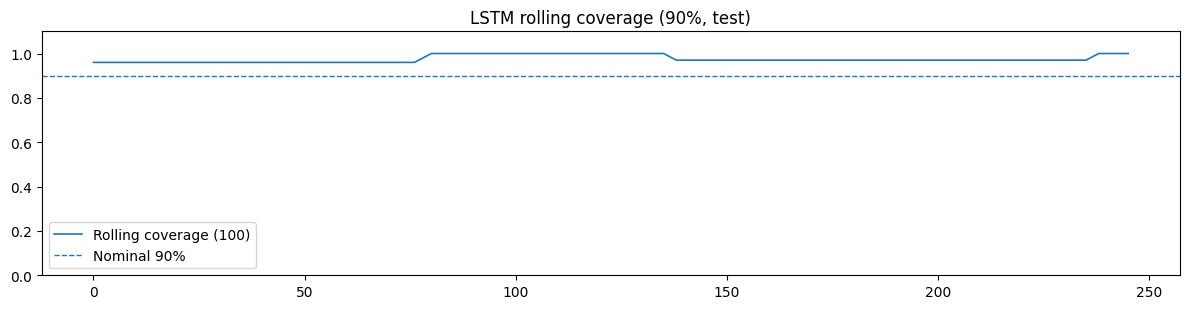

In [ ]:
def lstm_predict_quantiles(model, X, quantiles, scaler_y):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        Q = model(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy()  # (N, nq)
    # inverse scale quantiles to *log* units
    mu, sd = float(scaler_y.mean_[0]), float(scaler_y.scale_[0])
    Q_log = Q * sd + mu
    return Q_log  # only quantiles; y comes from the split input

def evaluate_split_lstm(name, X, y_std, quantiles, scaler_y, save_prefix="lstm", alpha=0.10):
    # 1) predictions and true y in *log* units
    Q_log = lstm_predict_quantiles(model, X, quantiles, scaler_y)  # (N, nq)
    y_log = scaler_y.inverse_transform(np.asarray(y_std).reshape(-1,1)).ravel()  # (N,)
    assert Q_log.shape[0] == y_log.shape[0], f"length mismatch: Q[{Q_log.shape[0]}] vs y[{y_log.shape[0]}]"
    taus = np.array(quantiles, dtype=float)
    assert np.all(np.diff(taus) > 0), "Quantiles must be sorted ascending."

    # 2) point metrics from the median
    i_med = int(np.where(taus == 0.5)[0][0])
    yhat_med = Q_log[:, i_med]
    mae = float(mean_absolute_error(y_log, yhat_med))
    mse = float(mean_squared_error(y_log, yhat_med))

    a, b = 0.05, 0.95
    if a in taus and b in taus:
        i_lo, i_hi = int(np.where(taus==a)[0][0]), int(np.where(taus==b)[0][0])
        lo = Q_log[:, i_lo]; hi = Q_log[:, i_hi]
    else:
        lo = np.array([np.interp(a, taus, Q_log[i, :]) for i in range(Q_log.shape[0])])
        hi = np.array([np.interp(b, taus, Q_log[i, :]) for i in range(Q_log.shape[0])])


    covered = ((y_log >= lo) & (y_log <= hi)).astype(float)
    cov = float(np.mean(covered))
    wid = float(np.mean(hi - lo))

    def interval_score(alpha, l, u, y):
        width = u - l
        under = np.maximum(l - y, 0.0)
        over  = np.maximum(y - u, 0.0)
        return width + (2.0/alpha)*(under + over)
    is90 = float(np.mean(interval_score(alpha, lo, hi, y_log)))

    # 4) CRPS from quantiles 
    def crps_from_quantiles(y, qs, taus):
        y = y.reshape(-1,1)
        err = y - qs
        pin = np.maximum((taus - 1.0) * err, taus * err)
        return 2.0 * np.trapz(pin, x=taus, axis=1)
    crps = float(np.mean(crps_from_quantiles(y_log, Q_log, taus)))

    print(f"[{name}] MAE={mae:.6f}  MSE={mse:.6f}  Cov90={cov:.3f}  Width90={wid:.6f}  IS90={is90:.6f}  CRPS={crps:.6f}")

    #  PIT histogram 
    pit = np.empty_like(y_log)
    for i in range(len(y_log)):
        qs_i = Q_log[i]
        if y_log[i] <= qs_i[0]:
            pit[i] = 0.0
        elif y_log[i] >= qs_i[-1]:
            pit[i] = 1.0
        else:
            j = np.searchsorted(qs_i, y_log[i])
            ql, qh = qs_i[j-1], qs_i[j]
            tl, th = taus[j-1], taus[j]
            w = (y_log[i] - ql) / max(qh - ql, 1e-12)
            pit[i] = (1-w)*tl + w*th

    plt.figure(figsize=(6,4))
    plt.hist(np.clip(pit,0,1), bins=20, range=(0,1), density=True, edgecolor="k")
    plt.axhline(1.0, ls="--", lw=1.0); plt.title(f"PIT histogram ({name}, log)")
    plt.tight_layout(); plt.savefig(f"plots/lstm/lstm_{name.lower()}_pit.png", dpi=160); plt.show()

    #  Reliability: quantiles 
    qgrid = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
    emp = []
    for p in qgrid:
        if p in taus:
            q_p = Q_log[:, int(np.where(taus==p)[0][0])]
        else:
            q_p = np.interp(p, taus, Q_log.T).T
        emp.append(float(np.mean(y_log <= q_p)))
    emp = np.array(emp)

    xx = np.linspace(0,1,201)
    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(qgrid, emp, "o-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal quantile level p"); plt.ylabel(r"Empirical $P(Y <= q_p)$")
    plt.title(f"Reliability — quantiles ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/lstm/lstm_{name.lower()}_reliab_quant.png", dpi=160); plt.show()

    #  Reliability: central intervals 
    cgrid = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
    emp_c = []
    for c in cgrid:
        a = (1 - c) / 2.0
        b = 1.0 - a
        if (a in taus) and (b in taus):
            q_a = Q_log[:, int(np.where(taus==a)[0][0])]
            q_b = Q_log[:, int(np.where(taus==b)[0][0])]
        else:
            q_a = np.array([np.interp(a, taus, Q_log[i, :]) for i in range(Q_log.shape[0])])
            q_b = np.array([np.interp(b, taus, Q_log[i, :]) for i in range(Q_log.shape[0])])
        emp_c.append(float(np.mean((y_log >= q_a) & (y_log <= q_b))))
    emp_c = np.array(emp_c)

    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(cgrid, emp_c, "s-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal central coverage"); plt.ylabel("Empirical coverage")
    plt.title(f"Reliability — central intervals ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/lstm/lstm_{name.lower()}_reliab_central.png", dpi=160); plt.show()

    #  Rolling 90% coverage 
    win = 100
    if len(covered) >= win:
        roll = np.convolve(covered, np.ones(win)/win, mode="valid")
        plt.figure(figsize=(12,3.2))
        plt.plot(roll, lw=1.2, label=f"Rolling coverage ({win})")
        plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
        plt.ylim(0,1.1); plt.legend()
        plt.title(f"LSTM rolling coverage (90%, {name})")
        plt.tight_layout()
        plt.savefig(f"plots/lstm/lstm_{name.lower()}_rolling_cov.png", dpi=160); plt.show()


    import pandas as pd, os
    os.makedirs("plots/lstm", exist_ok=True)
    row = {"Split": name, "MAE": mae, "MSE": mse, "Coverage90": cov, "Width90": wid, "IS90": is90, "CRPS": crps}
    pd.DataFrame([row]).to_csv(f"plots/lstm/lstm_{name.lower()}_metrics_log.csv", index=False)

    return {"MAE": mae, "MSE": mse, "Coverage90": cov, "Width90": wid, "IS90": is90, "CRPS": crps,
            "y_log": y_log, "Q_log": Q_log, "taus": taus, "lo": lo, "hi": hi}

res_te = evaluate_split_lstm("test",  X_te, y_te, quantiles, scaler_y, save_prefix="lstm")


[LSTM ACI] q̂_(1-α) from validation (w0): 0.908
[LSTM + ACI lag 30] MSE(log)=0.072740  Coverage=0.925  Width=1.302367  IS90=1.400827


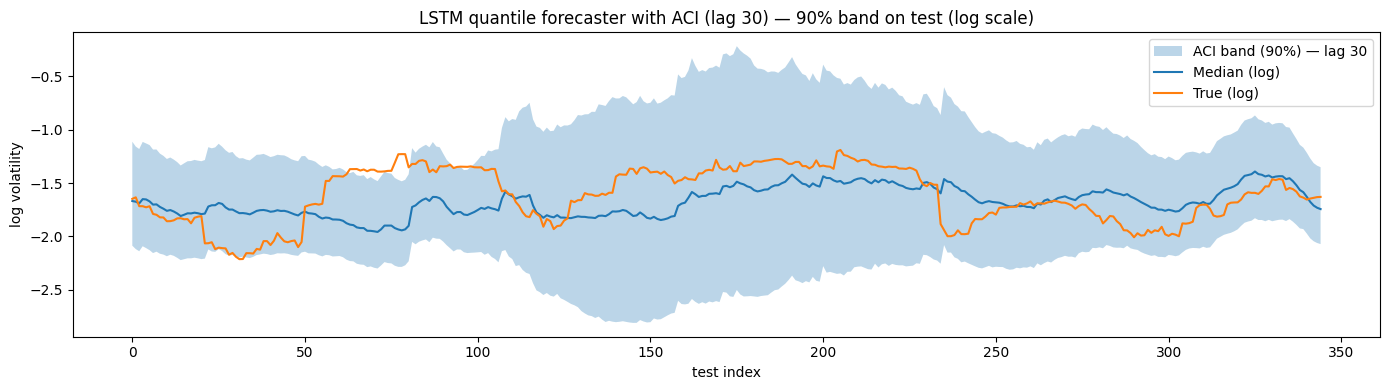

[Saved] plots/lstm/lstm_aci_test_band_log.png and plots/lstm/lstm_aci_test_metrics_log.csv


In [ ]:
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

os.makedirs("plots/lstm", exist_ok=True)

alpha  = 0.10     # 90% central interval
H      = 30       # horizon lag
beta   = 0.90     # EMA smoothing for misses
k_gain = 0.06     # multiplicative gain
w_min  = 0.05     # anti-windup
w_max  = 5.00
eps    = 1e-12

taus = np.array(quantiles, dtype=float)
i05  = int(np.where(taus == 0.05)[0][0])
i50  = int(np.where(taus == 0.50)[0][0])
i95  = int(np.where(taus == 0.95)[0][0])

Q_va_log = lstm_predict_quantiles(model, X_va, quantiles, scaler_y)            
y_va_log = scaler_y.inverse_transform(np.asarray(y_va).reshape(-1,1)).ravel()  

med_va   = Q_va_log[:, i50]
d_lo_va  = np.maximum(med_va - Q_va_log[:, i05], eps)      # half-widths
d_hi_va  = np.maximum(Q_va_log[:, i95] - med_va, eps)

w_req    = np.where(
    y_va_log < med_va,
    (med_va - y_va_log) / d_lo_va,
    (y_va_log - med_va) / d_hi_va
)
w_req = np.maximum(w_req, 0.0) 
w0    = float(np.quantile(w_req[np.isfinite(w_req)], 1 - alpha))  # 90% central coverage target
w0    = float(np.clip(w0, w_min, w_max))
print(f"[LSTM ACI] q̂_(1-α) from validation (w0): {w0:.3f}")

Q_te_log = lstm_predict_quantiles(model, X_te, quantiles, scaler_y)            # (N_te, nq)
y_te_log = scaler_y.inverse_transform(np.asarray(y_te).reshape(-1,1)).ravel()  # (N_te,)

med_te   = Q_te_log[:, i50]
d_lo_te  = np.maximum(med_te - Q_te_log[:, i05], eps)
d_hi_te  = np.maximum(Q_te_log[:, i95] - med_te, eps)

n_te = len(y_te_log)
mu_arr = med_te.copy()
lo_arr = np.full(n_te, np.nan)
hi_arr = np.full(n_te, np.nan)
w_used = np.full(n_te, np.nan)

w = float(w0)
miss_ema = alpha  # neutral start

for i in range(n_te):
    lo_arr[i] = mu_arr[i] - w * d_lo_te[i]
    hi_arr[i] = mu_arr[i] + w * d_hi_te[i]
    w_used[i] = w

    j = i - H
    if j >= 0 and np.isfinite(y_te_log[j]) and np.isfinite(lo_arr[j]) and np.isfinite(hi_arr[j]):
        miss = 0.0 if (lo_arr[j] <= y_te_log[j] <= hi_arr[j]) else 1.0
        miss_ema = beta * miss_ema + (1 - beta) * miss
        w = float(np.clip(w * np.exp(k_gain * (miss_ema - alpha)), w_min, w_max))

#  Metrics 
mask = np.isfinite(mu_arr) & np.isfinite(lo_arr) & np.isfinite(hi_arr) & np.isfinite(y_te_log)
y_eff  = y_te_log[mask]
mu_eff = mu_arr[mask]
lo_eff = lo_arr[mask]
hi_eff = hi_arr[mask]

def interval_score(alpha, l, u, y):
    width = u - l
    return width + (2.0/alpha)*np.maximum(l - y, 0.0) + (2.0/alpha)*np.maximum(y - u, 0.0)

cov  = float(np.mean((y_eff >= lo_eff) & (y_eff <= hi_eff)))
wid  = float(np.mean(hi_eff - lo_eff))
mse  = float(mean_squared_error(y_eff, mu_eff))
is90 = float(np.mean([interval_score(alpha, lo_eff[t], hi_eff[t], y_eff[t]) for t in range(len(y_eff))]))

print(f"[LSTM + ACI lag {H}] MSE(log)={mse:.6f}  Coverage={cov:.3f}  Width={wid:.6f}  IS90={is90:.6f}")

#  Plot 
x = np.arange(n_te)
plt.figure(figsize=(14,4))
plt.fill_between(x, lo_arr, hi_arr, alpha=.30, label=f'ACI band (90%) — lag {H}')
plt.plot(mu_arr, label='Median (log)'); plt.plot(y_te_log, label='True (log)')
plt.title(f'LSTM quantile forecaster with ACI (lag {H}) — 90% band on test (log scale)')
plt.xlabel('test index'); plt.ylabel('log volatility'); plt.legend()
plt.tight_layout()
plt.savefig("plots/lstm/lstm_aci_test_band_log.png", dpi=160)
plt.show()

import pandas as pd
row = {
    "Model": "LSTM + ACI (lag 30)",
    "MSE_log": mse, "Coverage90": cov, "AvgWidth90": wid, "IntervalScore90": is90,
    "alpha": alpha, "H": H, "beta": beta, "k": k_gain, "w0": w0
}
pd.DataFrame([row]).to_csv("plots/lstm/lstm_aci_test_metrics_log.csv", index=False)
print("[Saved] plots/lstm/lstm_aci_test_band_log.png and plots/lstm/lstm_aci_test_metrics_log.csv")


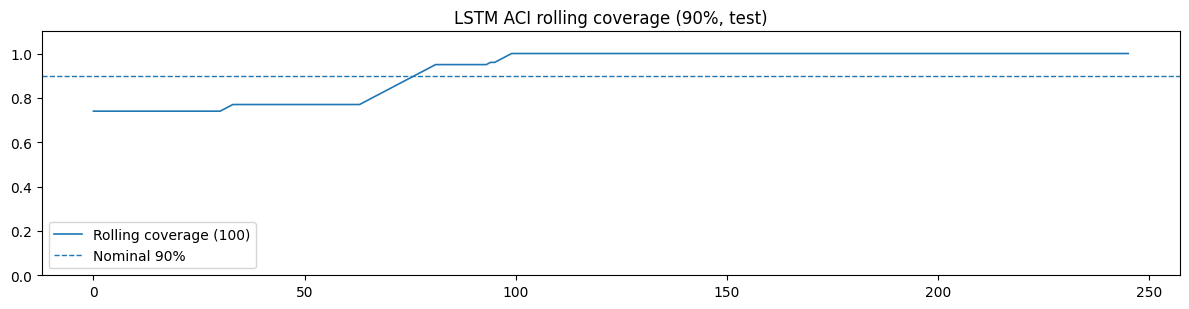

In [ ]:
#  Rolling coverage of the ACI band 
import numpy as np, matplotlib.pyplot as plt, os

os.makedirs("plots/lstm", exist_ok=True)

win = 100
covered_aci = ((y_te_log >= lo_arr) & (y_te_log <= hi_arr)).astype(float)
if len(covered_aci) >= win:
    roll_aci = np.convolve(covered_aci, np.ones(win)/win, mode="valid")
    plt.figure(figsize=(12,3.2))
    plt.plot(roll_aci, lw=1.2, label=f"Rolling coverage ({win})")
    plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
    plt.ylim(0, 1.1); plt.legend()
    plt.title("LSTM ACI rolling coverage (90%, test)")
    plt.tight_layout()
    plt.savefig("plots/lstm/lstm_aci_coverage_by_time.png", dpi=160)
    plt.show()
else:
    print(f"[ACI] Not enough points for rolling window (need ≥ {win}, have {len(covered_aci)}).")
